# PREDICCIÓN DEL FACTOR DE COMPRESIBILIDAD DE UN GAS NATURAL PARA ISOTÉRMAS USANDO MÉTODOS INTELIGENTES
Desarrollo de un proyecto para predecir el factor de compresibilidad del gas natural con las siguientes composiciones (metano,etano,propano,i-butano,n-butano,\
i-pentano,n-pentano,n-hexano,nitrogeno y dióxido de carbono) para diversas datas bibliográficas de isotérmas utilizando Redes Neuronales Artificiales Difusas (ANFIS) y Redes Neuronales Artificiales (ANN) en Python, comparando los resultados con las ecuaciones de estado de Peng-Robinson y Soave-Redlich-Kwong.

Referencias:
* [Prediction of gas compressibility factor using intelligent models](https://doi.org/10.1016/j.ngib.2015.09.001), Mohamadi(2015)
* [A New Correlation Based on Artificial Neural Networks for Predicting the Natural Gas Compressibility Factor](https://doi.org/10.1134/S1810232812040030), Baniasadi(2012)
* [Predicting the Compressibility Factor of Natural Gas by Using Statistical Modeling and Neural Network](https://doi.org/10.3390/en15051807), Ghanem(2022)

Data de Referencia:
* [Compressibility Isotherms of Simulated Natural Gases](https://doi.org/10.1021/je00059a011), Biswas(1990)
* [Isochoric (P,$\rho$,T) measurements for five natural gas mixtures from T (225 to 350)K at pressures to 35 MPa](https://doi.org/10.1006/jcht.1997.0259), Magee(1997)
* [Isothermal pVT measurements on gas hydrocarbon mixtures using a vibrating-tube apparatus](https://doi.org/10.1006/jcht.2001.0935), Capla(2002)

In [81]:
#Importando módulos
import sys
import io

#Gradicas y propiedades
import thermo as th
import chemicals as ch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

#Predicción
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


In [82]:
#PROPIEDADES
#Tomar datos de constantes y propiedades criticas
N_C=["methane","ethane","propane","i-butane","n-butane","i-pentane","n-pentane","n-hexane"]
#Se buscan componentes en base de datos
v_n=list(range(0,len(N_C)))
v_c=[ch.search_chemical(N_C[k]).InChI_key for k in v_n]
constants,propierties=th.ChemicalConstantsPackage.from_IDs(v_c)
#Se añaden datos de componentes no disponibles con InChI_key y se utiliza CAS.
N2_CO2_CAS=[ch.CAS_from_any('Nitrogen'),ch.CAS_from_any('Carbon dioxide')]
N2_CO2_Tcs=[ch.Tc(N2_CO2_CAS[0]),ch.Tc(N2_CO2_CAS[1])]
N2_CO2_Pcs=[ch.Pc(N2_CO2_CAS[0]),ch.Pc(N2_CO2_CAS[1])]
N2_CO2_ws=[ch.omega(N2_CO2_CAS[0]),ch.omega(N2_CO2_CAS[1])]
#Se buscan los parametros de interaccion binarias
#Se añaden datos de N2 y CO2, uniendo listas
#Union de lista de CAS
m_kij=th.interaction_parameters.IPDB.get_ip_asymmetric_matrix('ChemSep PR',
                                                              constants.CASs+N2_CO2_CAS,'kij')
#Union interna de propiedades criticas
DATA={'Pcs':constants.Pcs+N2_CO2_Pcs,
      'Tcs':constants.Tcs+N2_CO2_Tcs,
      'omegas':constants.omegas+N2_CO2_ws}

print(DATA)

{'Pcs': [4599200.0, 4872200.0, 4251200.0, 3629000.0, 3796000.0, 3378000.0, 3367500.0, 3044100.0, 3395800.0, 7377300.0], 'Tcs': [190.564, 305.322, 369.89, 407.81, 425.125, 460.35, 469.7, 507.82, 126.192, 304.1282], 'omegas': [0.01142, 0.0995, 0.1521, 0.184, 0.201, 0.2274, 0.251, 0.3, 0.0372, 0.22394]}


In [83]:
#IMPORTACIÓN DE BASE DE DATOS (se puede cambiar de acuerdo a la data)
# Leer base de datos
basedatos = pd.read_excel(r'C:\Users\cesar\Desktop\Proyecto-Gas Natural\data_isotermas.xlsx', sheet_name='DATA')
# Lista para almacenar resultados
results = []
# Número de filas
lon = len(basedatos.index)
# Visualizar la base de datos
basedatos.head()

,T (K),P(Pa),CH4,C2H6,C3H8,i-C4H10,n-C4H10,i-C5H12,n-C5H12,n-C6H14,N2,CO2,ρ exp (mol/dm3),Z exp
0,225.0,3193190.0,0.81299,0.03294,0.00637,0.00101,0.001,0.0,0.0,0.0,0.13575,0.00994,2.0050,0.85127
1,225.0,4512100.0,0.81299,0.03294,0.00637,0.00101,0.001,0.0,0.0,0.0,0.13575,0.00994,3.0789,0.78334
2,225.0,14818200.0,0.81299,0.03294,0.00637,0.00101,0.001,0.0,0.0,0.0,0.13575,0.00994,14.0370,0.56427
3,225.0,19712390.0,0.81299,0.03294,0.00637,0.00101,0.001,0.0,0.0,0.0,0.13575,0.00994,16.0959,0.65462
4,250.0,1996080.0,0.81299,0.03294,0.00637,0.00101,0.001,0.0,0.0,0.0,0.13575,0.00994,1.0080,0.93835


In [84]:
basedatos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   T (K)            426 non-null    float64
 1   P(Pa)            426 non-null    float64
 2   CH4              426 non-null    float64
 3   C2H6             426 non-null    float64
 4   C3H8             426 non-null    float64
 5   i-C4H10          426 non-null    float64
 6   n-C4H10          426 non-null    float64
 7   i-C5H12          426 non-null    float64
 8   n-C5H12          426 non-null    float64
 9   n-C6H14          426 non-null    float64
 10  N2               426 non-null    float64
 11  CO2              426 non-null    float64
 12  ρ exp (mol/dm3)  426 non-null    float64
 13  Z exp            426 non-null    float64
dtypes: float64(14)
memory usage: 46.7 KB


In [85]:
basedatos.describe()

,T (K),P(Pa),CH4,C2H6,C3H8,i-C4H10,n-C4H10,i-C5H12,n-C5H12,n-C6H14,N2,CO2,ρ exp (mol/dm3),Z exp
count,426.000000,4.260000e+02,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000
mean,289.187775,1.107037e+07,0.867847,0.051115,0.014873,0.001657,0.003958,0.000359,0.000365,0.000161,0.040602,0.019067,6.020992,0.830186
std,32.663720,8.462415e+06,0.056640,0.028207,0.016227,0.001747,0.004811,0.000665,0.000676,0.000247,0.044753,0.025781,4.677324,0.120819
min,225.000000,1.208300e+05,0.800780,0.018150,0.004050,0.000000,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048800,0.385000
25%,263.152000,4.222648e+06,0.812990,0.032940,0.006370,0.000990,0.001020,0.000000,0.000000,0.000000,0.010070,0.004660,2.003150,0.752370
50%,280.000000,8.986855e+06,0.858980,0.043060,0.008940,0.001010,0.001560,0.000300,0.000320,0.000000,0.026930,0.009360,4.357350,0.854520
75%,323.148000,1.596908e+07,0.906440,0.061150,0.015130,0.001480,0.003470,0.000470,0.000450,0.000400,0.057030,0.014980,9.946350,0.927115
max,349.981000,3.464920e+07,0.965800,0.116420,0.065300,0.007550,0.017500,0.002990,0.003040,0.000630,0.135750,0.075920,16.095900,0.997580


## Ecuaciones de Peng-Robinson(PR) y Soaver-Redlich-Kwong(SRK)
Se utiliza los módulos [thermo](https://pypi.org/project/thermo/) y [chemicals](https://pypi.org/project/chemicals/) para el calculo de las propiedades termodinámicas para gases reales con respectos a las Ecuaciones de Estado de Peng-Robinson(PR) y Soaver-Redlich-Kwong(SRK), asi como el cálculo de las propiedades pseudoreducidas($P_{pr},T_{pr}$) y un coeficiente $X$ que relaciona a estas dos, estos valores del gas natural estudiado permitirá tener valores en rangos pequeños para poder utilizar nuestro modelo de Predicción.

In [86]:
#CALCULOS
for i in range(0, lon):
    # Datos del data frame
    R=8.3145
    T = basedatos.iloc[i, 0]
    P = basedatos.iloc[i, 1]
    X = basedatos.iloc[i, 2:12].tolist()  # Obtener las composiciones desde la columna 2 hasta 11
    rho_exp = basedatos.iloc[i, 12]
    Z_exp= basedatos.iloc[i, 13]
    #CALCULOS DE VALORES PSEUDOREDUCIDOS
    # Calculando las presiones y temperaturas pseudocríticas
    Ppc = sum([X[j] * DATA['Pcs'][j] for j in range(len(X))])
    Tpc = sum([X[j] * DATA['Tcs'][j] for j in range(len(X))])
    
    # Calculando las presiones y temperaturas pseudoreducidas
    Ppr = P / Ppc
    Tpr = T / Tpc
    equis= Ppr/Tpr

    #CALCULOS DE DENSIDADES POR EC.DE ESTADOS
    # Definición de ecuaciones de estado
    EOS_PRmix = th.PRMIX(Tcs=DATA['Tcs'], Pcs=DATA['Pcs'], omegas=DATA['omegas'],
                        zs=X, kijs=m_kij, T=T, P=P)
    EOS_SRKmix = th.SRKMIX(Tcs=DATA['Tcs'], Pcs=DATA['Pcs'], omegas=DATA['omegas'],
                        zs=X, kijs=m_kij, T=T, P=P)

    try:
        # Verifica si existen métodos para obtener el volumen molar
        if hasattr(EOS_PRmix, 'Z_g'):
            Z_PR = EOS_PRmix.to(T=T, P=P).Z_g
        else:
            Z_PR = EOS_PRmix.to(T=T, P=P).Z_l  # Usa Z_l como alternativa si no existe Z_g

        if hasattr(EOS_SRKmix, 'Z_g'):
            Z_SRK = EOS_SRKmix.to(T=T, P=P).Z_g
        else:
            Z_SRK = EOS_SRKmix.to(T=T, P=P).Z_l  # Usa Z_l como alternativa si no existe Z_g

    except AttributeError as e:
        print(f"Error al acceder a atributos: {e}")
    # Almacenar los resultados
    results.append([Ppr, Tpr, equis, Z_exp,Z_PR, Z_SRK])

# Crear un DataFrame con los resultados
columns = ['Ppr','Tpr','X','Z(exp)','Z(PR)','Z(SRK)']
data = pd.DataFrame(results, columns=columns)
data.head()

,Ppr,Tpr,X,Z(exp),Z(PR),Z(SRK)
0,0.714609,1.194707,0.598146,0.85127,0.831137,0.851514
1,1.009769,1.194707,0.845203,0.78334,0.758910,0.785745
2,3.316187,1.194707,2.775733,0.56427,0.553238,0.600779
3,4.411465,1.194707,3.692509,0.65462,0.626810,0.685755
4,0.446706,1.327452,0.336514,0.93835,0.925536,0.937494


In [87]:
## Normalizando los valores de Ppr,Tpr y X para usar en los modelos de predicción
scaler = StandardScaler()
data[['Ppr', 'Tpr', 'X']] = scaler.fit_transform(data[['Ppr', 'Tpr', 'X']])
data.head()

,Ppr,Tpr,X,Z(exp),Z(PR),Z(SRK)
0,-0.918927,-1.514769,-0.845877,0.85127,0.831137,0.851514
1,-0.758450,-1.514769,-0.651715,0.78334,0.758910,0.785745
2,0.495533,-1.514769,0.865487,0.56427,0.553238,0.600779
3,1.091028,-1.514769,1.585981,0.65462,0.626810,0.685755
4,-1.064584,-0.714518,-1.051493,0.93835,0.925536,0.937494


## Redes Neuronales Artificales (ANN)
En este caso luego de tener los datos normalizados empleamos la libreria [tensorflow](https://pypi.org/project/tensorflow/) usando el método de predicción realizado por el modelo de Adam para entrenar la red neuronal debido a su eficiencia y velocidad de convergencia. Adam combina las ventajas de los optimizadores AdaGrad y RMSProp, permitiendo una adaptación dinámica de las tasas de aprendizaje para cada parámetro, lo que resulta en un ajuste más efectivo, especialmente en problemas con datos ruidosos y complejos. Su capacidad para manejar momentos acumulados y su robustez lo convierten en una opción confiable para la regresión, facilitando un entrenamiento eficaz en el predicción del factor de compresibilidad $Z$. Además, su configuración predeterminada permite iniciar el proceso de entrenamiento sin la necesidad de un ajuste exhaustivo de hiperparámetros, lo que optimiza el flujo de trabajo en el análisis de datos experimentales.

In [88]:
# RED NEURONAL ARTIFICAL(ANN) con el modelo de ADAM
np.random.seed(42)
tf.random.set_seed(42)

# Asumir que el dataset tiene columnas ['Ppr', 'Tpr', 'X', 'Z(exp)']
x = data[['Ppr', 'Tpr', 'X']].values
y = data['Z(exp)'].values  # Verifica que el nombre de la columna sea correcto

# Definir la red neuronal
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)  # Una salida para predecir Z
])

# Compilar el modelo con el optimizador ADAM
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # Usamos el modelo ADAM
    loss='mean_squared_error',  # Usamos MSE porque es una regresión
    metrics=['mean_absolute_error']
)

# Crear un dataset de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((x, y))
train_dataset = train_dataset.batch(256)  # Ajustar el tamaño del batch según sea necesario

# Entrenar el modelo
model.fit(train_dataset, epochs=1000)
# Hacer predicciones
predictions = model.predict(x)
print('Predicciones finalizadas')
# Agregar predicciones al DataFrame
data['Z(ANN)'] = predictions

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.4472 - mean_absolute_error: 0.6561
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2069 - mean_absolute_error: 0.4231
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1159 - mean_absolute_error: 0.2963
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0987 - mean_absolute_error: 0.2346
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0966 - mean_absolute_error: 0.2350
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0844 - mean_absolute_error: 0.2310
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0613 - mean_absolute_error: 0.1996
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0456 - mean_absolute_error: 0.1700
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0432 - mean_absolute_error: 0.1713
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0450 - mean_absolute_error: 0.1789
Epoch 11/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 

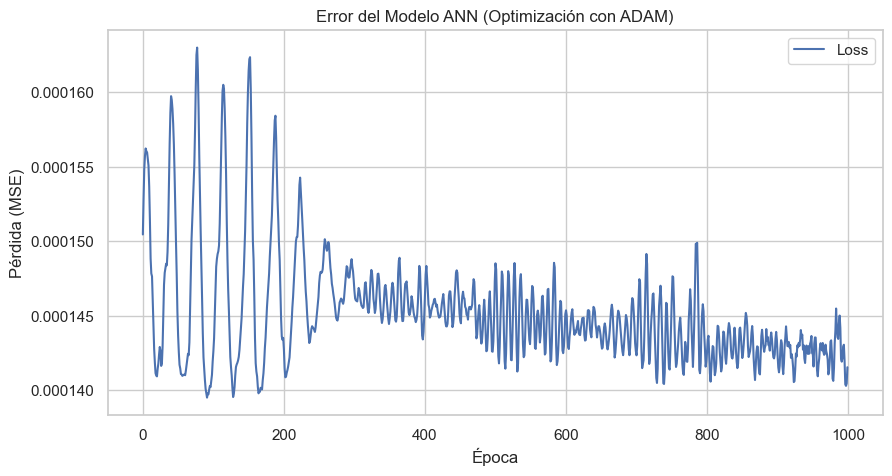

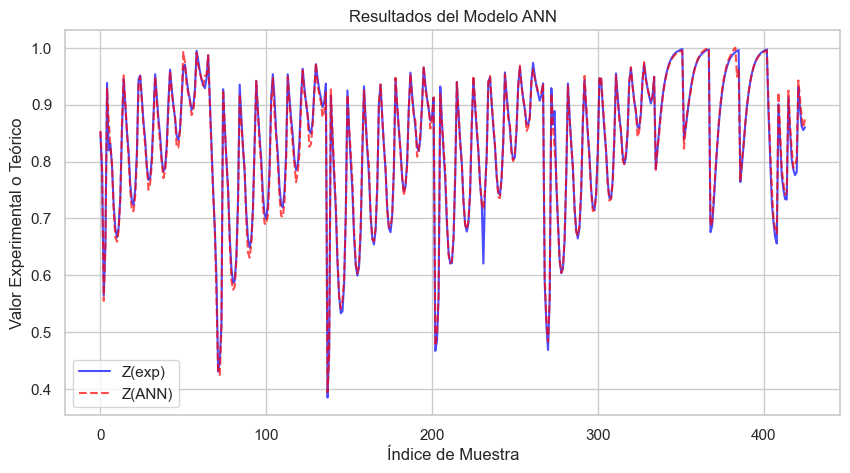

In [89]:
# Graficar el error del entrenamiento ANN (historia de entrenamiento)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.title('Error del Modelo ANN (Optimización con ADAM)')
plt.legend()
plt.show()

# Mostrar los resultados del modelo ANN comparados con Z(exp)
plt.figure(figsize=(10, 5))
plt.plot(data['Z(exp)'], label='Z(exp)', color='blue', linestyle='-', alpha=0.7)
plt.plot(data['Z(ANN)'], label='Z(ANN)', color='red', linestyle='--', alpha=0.7)
plt.xlabel('Índice de Muestra')
plt.ylabel('Valor Experimental o Teórico')
plt.title('Resultados del Modelo ANN')
plt.legend()
plt.show()

In [90]:
data.head()

,Ppr,Tpr,X,Z(exp),Z(PR),Z(SRK),Z(ANN)
0,-0.918927,-1.514769,-0.845877,0.85127,0.831137,0.851514,0.853999
1,-0.758450,-1.514769,-0.651715,0.78334,0.758910,0.785745,0.786481
2,0.495533,-1.514769,0.865487,0.56427,0.553238,0.600779,0.555012
3,1.091028,-1.514769,1.585981,0.65462,0.626810,0.685755,0.652548
4,-1.064584,-0.714518,-1.051493,0.93835,0.925536,0.937494,0.928310


## Redes Neuronales Artificiales Difusas (ANFIS)
El modelo ANFIS (Sistema de Inferencia Adaptativa Basado en Redes Neuronales) es óptimo para la predicción del factor de compresibilidad 
𝑍 debido a su integración de la lógica difusa y las redes neuronales, lo que le permite modelar relaciones no lineales complejas en los datos con mayor precisión. Esta combinación ofrece interpretabilidad a través de reglas difusas que explican la relación entre las variables de entrada $P_{pr}$,$T_{pr}$ y $X$ la salida, facilitando la comprensión del modelo. La lógica difusa es esencial porque captura la incertidumbre e imprecisión de los datos, representando las variables en un espectro continuo y estableciendo reglas de inferencia que reflejan relaciones complejas. Con funciones de membresía que evalúan grados de pertenencia, ANFIS se adapta eficazmente a las variaciones en los datos y permite incorporar conocimiento experto en sus reglas, resultando en predicciones más precisas y confiables. En comparación con modelos tradicionales como ANN, PR y SRK, ANFIS destaca al abordar no solo patrones lineales, sino también interacciones complejas, convirtiéndose en una herramienta poderosa en contextos donde la incertidumbre es significativa.

In [91]:
# Definimos los valores estadísticos para poder establecer las funciones de membresia del modelo
data.describe()

,Ppr,Tpr,X,Z(exp),Z(PR),Z(SRK),Z(ANN)
count,4.260000e+02,4.260000e+02,4.260000e+02,426.000000,426.000000,426.000000,426.000000
mean,1.167558e-16,-9.173674e-16,1.334353e-16,0.830186,0.812970,0.848090,0.829066
std,1.001176e+00,1.001176e+00,1.001176e+00,0.120819,0.120516,0.112477,0.120427
min,-1.293167e+00,-2.175385e+00,-1.302035e+00,0.385000,0.380997,0.417298,0.394683
25%,-8.052580e-01,-6.524621e-01,-8.089775e-01,0.752370,0.734174,0.782861,0.752364
50%,-2.380152e-01,-4.924795e-02,-2.894237e-01,0.854520,0.831778,0.869998,0.854090
75%,5.848586e-01,5.698793e-01,6.286379e-01,0.927115,0.906826,0.936520,0.921694
max,2.908447e+00,2.485878e+00,2.921182e+00,0.997580,0.996806,1.024800,1.000356


In [92]:
# RED NEURONAL ARTIFICAL DIFUSA(ANFIS)
#Importación de la libreria anfis(modificada debido a la presencia de errores)
#Ref: https://github.com/twmeggs/anfis
import sys
sys.path.append("..")
import anfis_ejm as anfys

# Seleccionar las primeras tres columnas como entradas (Ppr, Tpr, X)
X = data.iloc[:, 0:3].values
# Seleccionar la cuarta columna como salida (Z_exp)
Y = data.iloc[:, 3].values

# Diseñar las funciones de membresía especificando la media y sigma
mf = [
    [['gaussmf', {'mean': 1, 'sigma': 0.5}],   # Función para Ppr
     ['gaussmf', {'mean': 0.5, 'sigma': 0.5}],
     ['gaussmf', {'mean': 0, 'sigma': 0.5}],
     ['gaussmf', {'mean': -0.5, 'sigma': 0.5}],
     ['gaussmf', {'mean': -1, 'sigma': 0.5}]],

    [['gaussmf', {'mean': 1, 'sigma': 0.5}],   # Función para Tpr
     ['gaussmf', {'mean': 0.5, 'sigma': 0.5}],
     ['gaussmf', {'mean': 0, 'sigma': 0.5}],
     ['gaussmf', {'mean': -0.5, 'sigma': 0.5}],
     ['gaussmf', {'mean': -1, 'sigma': 0.5}]],

    [['gaussmf', {'mean': 1, 'sigma': 0.5}],   # Función para X
     ['gaussmf', {'mean': 0.5, 'sigma': 0.5}],
     ['gaussmf', {'mean': 0, 'sigma': 0.5}],
     ['gaussmf', {'mean': -0.5, 'sigma': 0.5}],
     ['gaussmf', {'mean': -1, 'sigma': 0.5}]]
]

# Crear un objeto para las funciones de membresía
mfc = anfys.MemFuncs(mf)

# Crear un objeto ANFIS
anf = anfys.ANFIS(X, Y, mfc)

# Método de entrenamiento híbrido fuera de línea
print("Entrenando el modelo ANFIS...")
Pred = anf.trainHybridJangOffLine(epochs=20)
print("Entrenamiento completo.")

#Agregar predicciones al DataFrame
data['Z(ANFIS)'] = Pred

Entrenando el modelo ANFIS...
current error:  0.04616408090081334
current error:  0.04617677371347302
current error:  0.04618858842765071
current error:  0.046199515710508676
current error:  0.04620956062860439
current error:  0.04621873965429193
current error:  0.04622707772609749
current error:  0.04623460547048351
current error:  0.046241356674300724
current error:  0.04624736607665959
current error:  0.04625266752686934
current error:  0.046257292532819655
current error:  0.0462612692028471
current error:  0.04626462156481703
current error:  0.04626736923012219
current error:  0.0462695273577654
current error:  0.0462711068654446
current error:  0.046272114830179414
current error:  0.04627255502050972
Entrenamiento completo.


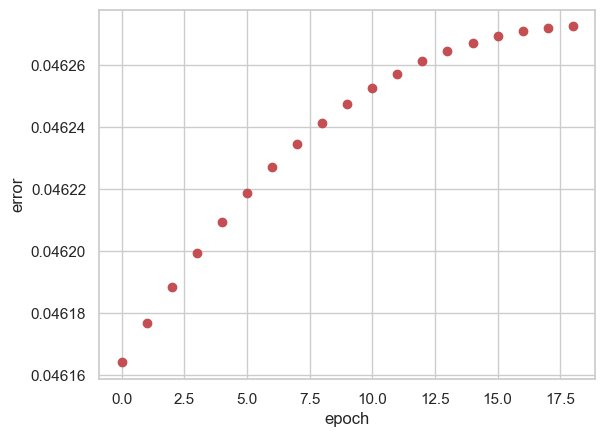

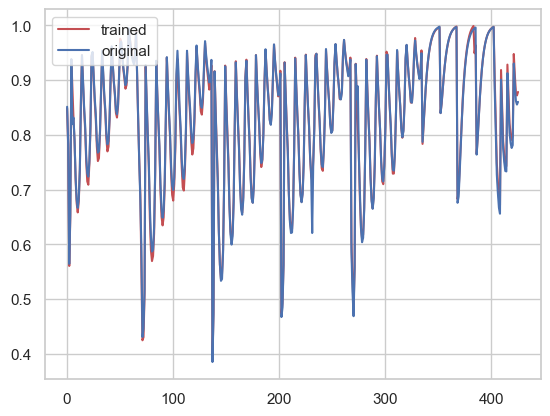

In [93]:
# Graficar el error del modelo
anf.plotErrors()
# Mostrando los resultados
anf.plotResults()

In [94]:
data.head()

,Ppr,Tpr,X,Z(exp),Z(PR),Z(SRK),Z(ANN),Z(ANFIS)
0,-0.918927,-1.514769,-0.845877,0.85127,0.831137,0.851514,0.853999,0.848266
1,-0.758450,-1.514769,-0.651715,0.78334,0.758910,0.785745,0.786481,0.780725
2,0.495533,-1.514769,0.865487,0.56427,0.553238,0.600779,0.555012,0.560475
3,1.091028,-1.514769,1.585981,0.65462,0.626810,0.685755,0.652548,0.649682
4,-1.064584,-0.714518,-1.051493,0.93835,0.925536,0.937494,0.928310,0.937233


## Gráficas de Comparación de los modelos respecto a los valores teóricos
Las gráficas de comparación de los modelos respecto a los valores teóricos se utilizan para evaluar visualmente la precisión y la validez de distintos modelos predictivos en relación con los valores experimentales o teóricos. En el contexto de la predicción del factor de compresibilidad $Z$, estas gráficas permiten comparar cómo se comportan los diferentes métodos (en este caso, los modelos PR, SRK, ANN y ANFIS) en su capacidad para replicar los datos observados.
Estas gráficas nos proporcionan una forma efectiva de identificar patrones y discrepancias entre las predicciones y los datos reales. Al incluir una línea de referencia (generalmente la línea de identidad $y=x$), se puede ver cuán cerca están las predicciones de los valores esperados. Además, calcular y mostrar el coeficiente de determinación $R^{2}$ nos ayuda a cuantificar la correlación y el ajuste entre los valores predichos y los experimentales, proporcionando una medida objetiva del rendimiento del modelo. En resumen, estas gráficas son esenciales para comparar la eficacia de los modelos y tomar decisiones fundamentadas sobre cuál de ellos se desempeña mejor en términos de precisión y consistencia.

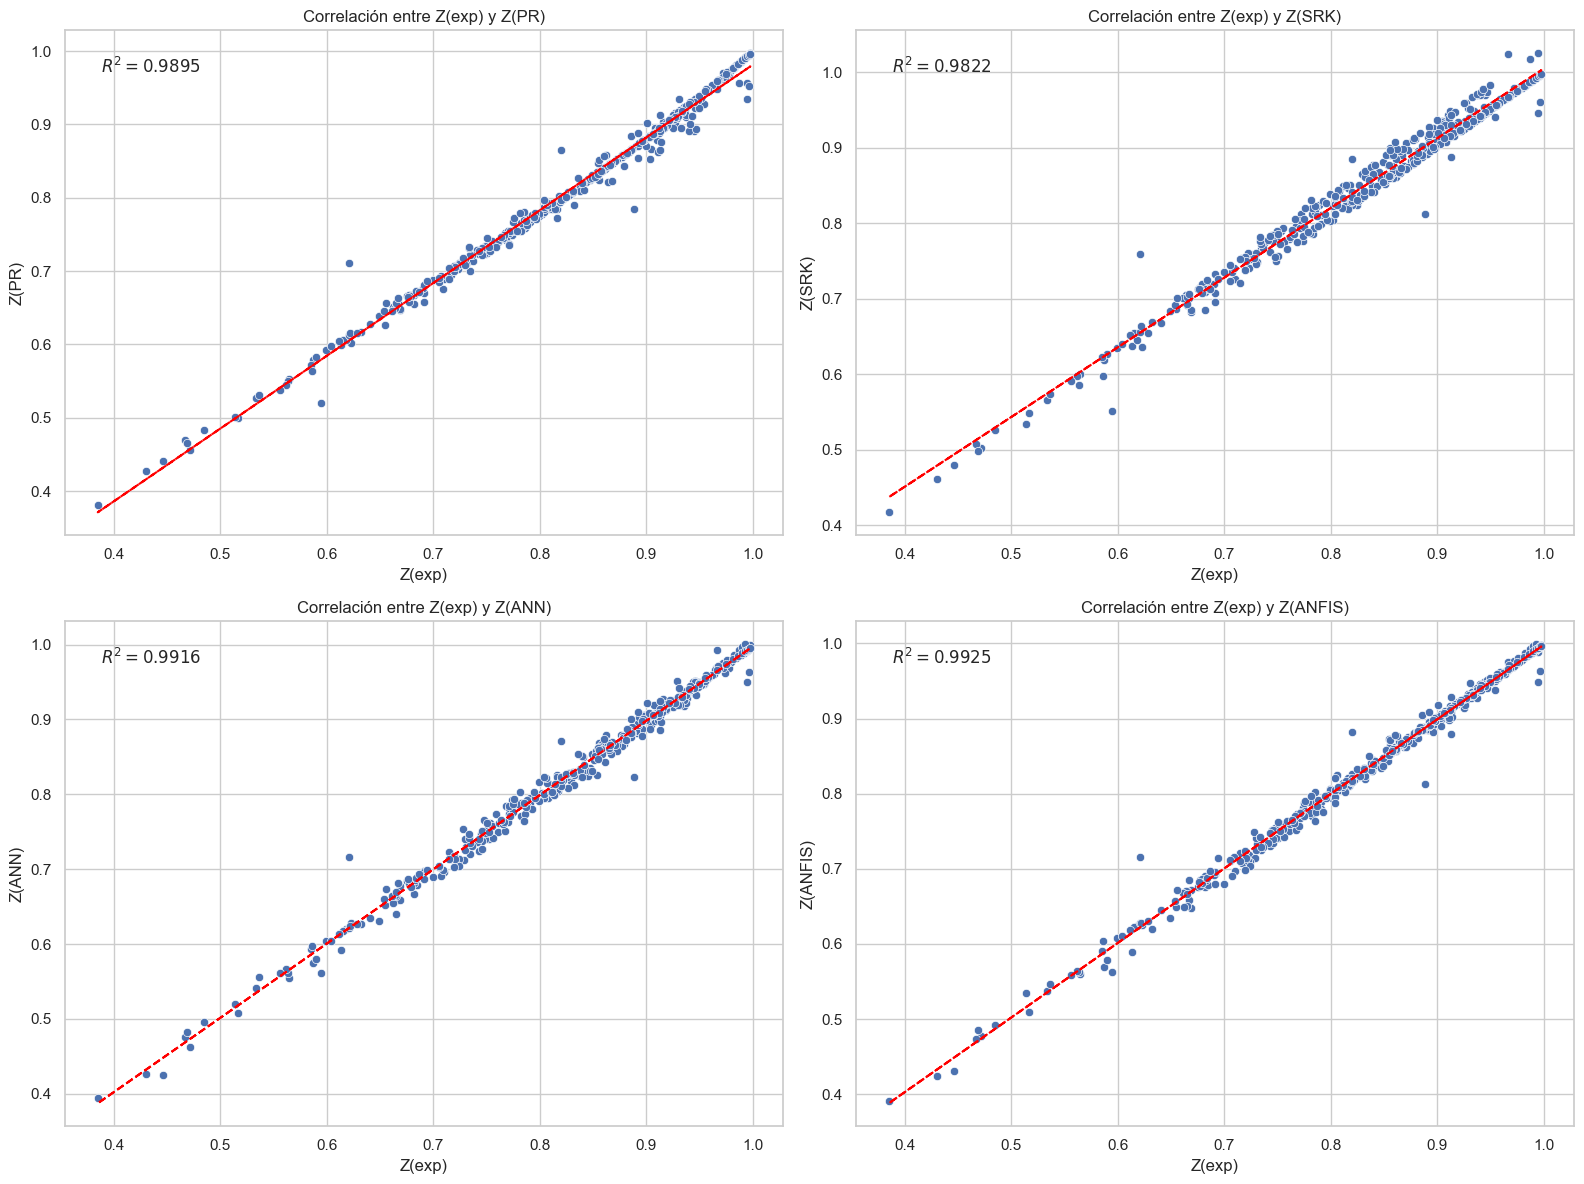

In [95]:
# Estableciendo el estilo de las gráficas
sns.set_theme(style='whitegrid')

# Creando un gráfico de dispersión para cada método en relación a 'Z(exp)'
plt.figure(figsize=(16, 12))

# Función para calcular y mostrar R^2 en los gráficos
def plot_with_r2(ax, x, y, title, xlabel, ylabel):
    # Calcular la regresión lineal
    slope, intercept, r_value, _, _ = linregress(x, y)
    r_squared = r_value**2
    
    # Crear el gráfico de dispersión
    sns.scatterplot(x=x, y=y, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Añadir línea de regresión
    ax.plot(x, slope * x + intercept, color='red', linestyle='--')
    
    # Mostrar el valor de R^2
    ax.text(0.05, 0.95, f'$R^2 = {r_squared:.4f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Gráficando para Z(PR)
ax1 = plt.subplot(2, 2, 1)
plot_with_r2(ax1, data['Z(exp)'], data['Z(PR)'], 'Correlación entre Z(exp) y Z(PR)', 'Z(exp)', 'Z(PR)')

# Gráficando para Z(SRK)
ax2 = plt.subplot(2, 2, 2)
plot_with_r2(ax2, data['Z(exp)'], data['Z(SRK)'], 'Correlación entre Z(exp) y Z(SRK)', 'Z(exp)', 'Z(SRK)')

# Gráficando para Z(ANN)
ax3 = plt.subplot(2, 2, 3)
plot_with_r2(ax3, data['Z(exp)'], data['Z(ANN)'], 'Correlación entre Z(exp) y Z(ANN)', 'Z(exp)', 'Z(ANN)')

# Gráficando para Z(ANFIS)
ax4 = plt.subplot(2, 2, 4)
plot_with_r2(ax4, data['Z(exp)'], data['Z(ANFIS)'], 'Correlación entre Z(exp) y Z(ANFIS)', 'Z(exp)', 'Z(ANFIS)')

# Ajustando el layout
plt.tight_layout()
plt.show()